In [1]:
import os
import numpy as np
import torch
from PIL import Image

In [2]:
class PennFudanDataset(object):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)
        # convert the PIL Image into a numpy array
        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [3]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
    

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    
    # mask rcnn commenting.
    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)
    
    

    return model

In [5]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [7]:
from engine import train_one_epoch, evaluate
import utils

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("device", device)

# our dataset has two classes only - background and person
num_classes = 2
# use our dataset and defined transformations
dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])


# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)

# get the model using our helper function
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

# let's train it for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)    
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

SAVED_PATH = './k_model_2019.06.24.pt'
# save the target path.
torch.save(model.state_dict(), SAVED_PATH)


device cuda
Epoch: [0]  [ 0/60]  eta: 0:00:28  lr: 0.000090  loss: 3.6972 (3.6972)  loss_classifier: 0.5435 (0.5435)  loss_box_reg: 0.1851 (0.1851)  loss_mask: 2.9436 (2.9436)  loss_objectness: 0.0108 (0.0108)  loss_rpn_box_reg: 0.0142 (0.0142)  time: 0.4823  data: 0.0331  max mem: 5598
Epoch: [0]  [10/60]  eta: 0:00:21  lr: 0.000936  loss: 1.4102 (1.9102)  loss_classifier: 0.3471 (0.3700)  loss_box_reg: 0.1851 (0.1961)  loss_mask: 0.8527 (1.3100)  loss_objectness: 0.0172 (0.0235)  loss_rpn_box_reg: 0.0101 (0.0105)  time: 0.4397  data: 0.0569  max mem: 5598
Epoch: [0]  [20/60]  eta: 0:00:18  lr: 0.001783  loss: 0.7226 (1.2874)  loss_classifier: 0.1790 (0.2667)  loss_box_reg: 0.1670 (0.1822)  loss_mask: 0.2695 (0.8050)  loss_objectness: 0.0221 (0.0226)  loss_rpn_box_reg: 0.0101 (0.0109)  time: 0.4598  data: 0.0724  max mem: 5744
Epoch: [0]  [30/60]  eta: 0:00:13  lr: 0.002629  loss: 0.4657 (1.0086)  loss_classifier: 0.0889 (0.2031)  loss_box_reg: 0.1478 (0.1676)  loss_mask: 0.2040 (0.60

 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.946
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.554
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.771
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.329
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.791
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.791
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.717
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.799
Epoch: [2]  [ 0/60]  eta: 0:00:25  lr: 0.005000  loss: 0.1745 (0.1745)  loss_classifier: 0.0113 (0.0113)  loss_box_reg: 0.0099 (0.0099)  loss_mask: 0.1475 (0.1475)  loss_objectness: 0.0003 (0.0003) 

 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.831
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.368
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.855
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.855
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.792
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.861
IoU metric: segm
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.770
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.994
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.954
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.606
 Average Precision  (

Test:  [49/50]  eta: 0:00:00  model_time: 0.0762 (0.0758)  evaluator_time: 0.0035 (0.0043)  time: 0.0985  data: 0.0148  max mem: 6432
Test: Total time: 0:00:04 (0.0971 s / it)
Averaged stats: model_time: 0.0762 (0.0758)  evaluator_time: 0.0035 (0.0043)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.825
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.994
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.967
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.672
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.837
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.368
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 

Epoch: [7]  [50/60]  eta: 0:00:04  lr: 0.000050  loss: 0.1471 (0.1586)  loss_classifier: 0.0200 (0.0255)  loss_box_reg: 0.0077 (0.0113)  loss_mask: 0.1057 (0.1135)  loss_objectness: 0.0003 (0.0007)  loss_rpn_box_reg: 0.0063 (0.0075)  time: 0.4288  data: 0.0493  max mem: 6432
Epoch: [7]  [59/60]  eta: 0:00:00  lr: 0.000050  loss: 0.1426 (0.1580)  loss_classifier: 0.0182 (0.0246)  loss_box_reg: 0.0077 (0.0110)  loss_mask: 0.1056 (0.1143)  loss_objectness: 0.0002 (0.0007)  loss_rpn_box_reg: 0.0061 (0.0074)  time: 0.4395  data: 0.0571  max mem: 6432
Epoch: [7] Total time: 0:00:26 (0.4483 s / it)
creating index...
index created!
Test:  [ 0/50]  eta: 0:00:05  model_time: 0.0922 (0.0922)  evaluator_time: 0.0040 (0.0040)  time: 0.1133  data: 0.0160  max mem: 6432
Test:  [49/50]  eta: 0:00:00  model_time: 0.0742 (0.0756)  evaluator_time: 0.0030 (0.0044)  time: 0.0970  data: 0.0144  max mem: 6432
Test: Total time: 0:00:04 (0.0967 s / it)
Averaged stats: model_time: 0.0742 (0.0756)  evaluator_tim

Epoch: [9]  [20/60]  eta: 0:00:17  lr: 0.000005  loss: 0.1626 (0.1664)  loss_classifier: 0.0252 (0.0256)  loss_box_reg: 0.0099 (0.0129)  loss_mask: 0.1165 (0.1193)  loss_objectness: 0.0003 (0.0005)  loss_rpn_box_reg: 0.0077 (0.0080)  time: 0.4438  data: 0.0569  max mem: 6432
Epoch: [9]  [30/60]  eta: 0:00:13  lr: 0.000005  loss: 0.1518 (0.1657)  loss_classifier: 0.0274 (0.0263)  loss_box_reg: 0.0094 (0.0130)  loss_mask: 0.1134 (0.1182)  loss_objectness: 0.0002 (0.0005)  loss_rpn_box_reg: 0.0077 (0.0078)  time: 0.4569  data: 0.0687  max mem: 6432
Epoch: [9]  [40/60]  eta: 0:00:08  lr: 0.000005  loss: 0.1467 (0.1605)  loss_classifier: 0.0236 (0.0248)  loss_box_reg: 0.0090 (0.0122)  loss_mask: 0.1060 (0.1156)  loss_objectness: 0.0002 (0.0005)  loss_rpn_box_reg: 0.0065 (0.0075)  time: 0.4463  data: 0.0676  max mem: 6432
Epoch: [9]  [50/60]  eta: 0:00:04  lr: 0.000005  loss: 0.1276 (0.1576)  loss_classifier: 0.0210 (0.0250)  loss_box_reg: 0.0061 (0.0115)  loss_mask: 0.1003 (0.1131)  loss_ob

In [9]:
modelsaved = get_model_instance_segmentation(num_classes)
modelsaved.load_state_dict( torch.load(SAVED_PATH))
modelsaved.eval()
modelsaved.to(device)
img, _ = dataset_test[1]
# put the model in evaluation mode
modelsaved.eval()
with torch.no_grad():
    prediction = modelsaved([img.to(device)])


In [16]:
print(prediction[0]) # dict_keys(['boxes', 'labels', 'scores', 'masks'])

{'boxes': tensor([[273.0471,  43.6111, 385.7422, 309.4865],
        [404.1228,  36.4298, 477.6591, 307.9396],
        [192.5982,  41.5769, 417.8072, 301.9366],
        [354.5025,  44.1895, 515.8765, 309.5171]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9988, 0.9965, 0.3210, 0.1386], device='cuda:0'), 'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0.,

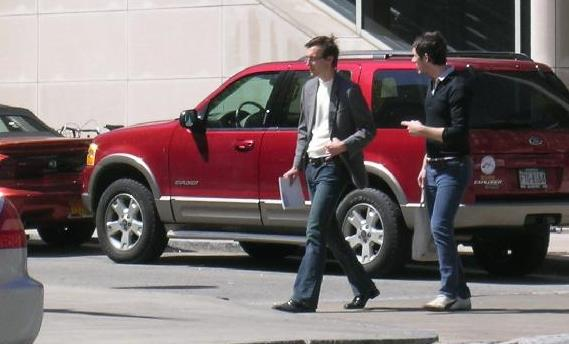

In [13]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())


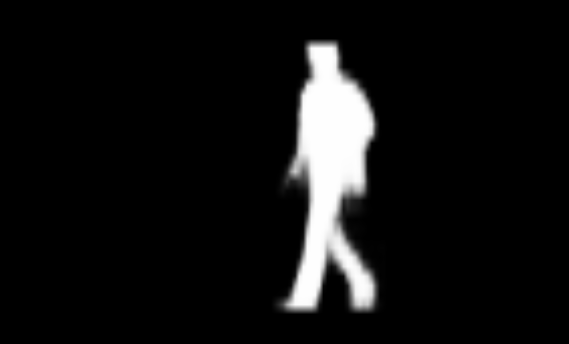

In [14]:
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())